Data loaded successfully!
Dataset shape: (4331, 22)

Starting training...
Epoch 10: Train Loss: 0.0612, Val Loss: 0.0519
Epoch 20: Train Loss: 0.0452, Val Loss: 0.0557
Early stopping triggered at epoch 22

Plotting results...


<ipython-input-1-6704bdde6d46>:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('best_model.pth'))


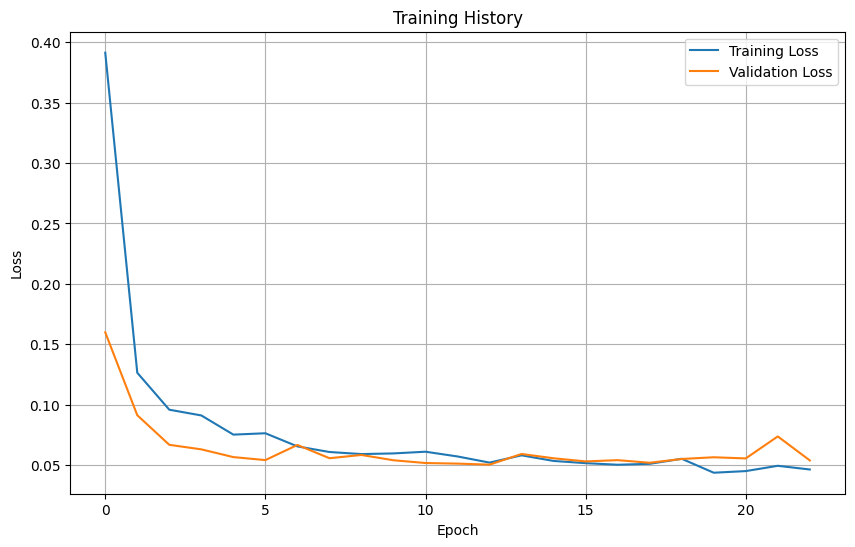

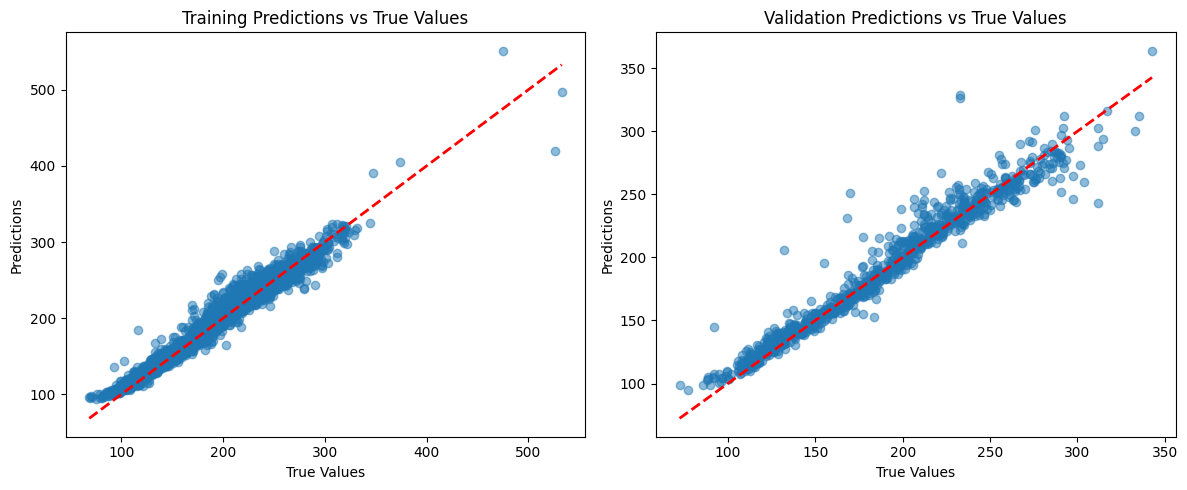


Final Metrics:
Training RMSE: 9.49
Validation RMSE: 12.06


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

class MortalityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class MortalityNet(nn.Module):
    def __init__(self, input_size):
        super(MortalityNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.layers(x)

class MortalityPredictor:
    def __init__(self, learning_rate=0.001, batch_size=32, epochs=100):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        self.history = {'train_loss': [], 'val_loss': []}

    def prepare_data(self, data):
        years = data['Year'].values - data['Year'].min()
        mortality_rates = data.select_dtypes(include=[np.number]).drop(['Year'], axis=1)
        X = np.column_stack((years, mortality_rates.iloc[:, :-1]))
        y = mortality_rates.iloc[:, -1].values.reshape(-1, 1)
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y)
        return X_scaled, y_scaled

    def create_dataloaders(self, X, y):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        train_dataset = MortalityDataset(X_train, y_train)
        val_dataset = MortalityDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size)
        return train_loader, val_loader, X_train, X_val, y_train, y_val

    def train(self, data):
        X, y = self.prepare_data(data)
        train_loader, val_loader, X_train, X_val, y_train, y_val = self.create_dataloaders(X, y)
        self.model = MortalityNet(X.shape[1])
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0

        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = self.model(X_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    y_pred = self.model(X_batch)
                    val_loss += criterion(y_pred, y_batch).item()

            avg_train_loss = train_loss/len(train_loader)
            avg_val_loss = val_loss/len(val_loader)

            self.history['train_loss'].append(avg_train_loss)
            self.history['val_loss'].append(avg_val_loss)

            if epoch % 10 == 0:
                print(f'Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(self.model.state_dict(), 'best_model.pth')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'Early stopping triggered at epoch {epoch}')
                    break

        self.model.load_state_dict(torch.load('best_model.pth'))

        self.model.eval()
        with torch.no_grad():
            train_preds = self.scaler_y.inverse_transform(
                self.model(torch.FloatTensor(X_train)).numpy()
            )
            val_preds = self.scaler_y.inverse_transform(
                self.model(torch.FloatTensor(X_val)).numpy()
            )

        return train_preds, val_preds, self.scaler_y.inverse_transform(y_train), self.scaler_y.inverse_transform(y_val)

    def plot_training_history(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.history['train_loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training History')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_predictions(self, train_preds, val_preds, y_train_true, y_val_true):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.scatter(y_train_true, train_preds, alpha=0.5)
        plt.plot([y_train_true.min(), y_train_true.max()],
                [y_train_true.min(), y_train_true.max()],
                'r--', lw=2)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.title('Training Predictions vs True Values')

        plt.subplot(1, 2, 2)
        plt.scatter(y_val_true, val_preds, alpha=0.5)
        plt.plot([y_val_true.min(), y_val_true.max()],
                [y_val_true.min(), y_val_true.max()],
                'r--', lw=2)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.title('Validation Predictions vs True Values')

        plt.tight_layout()
        plt.show()

def load_and_preprocess_data():
    df = pd.read_csv('annual-death-rate-by-age-group.csv')
    df.columns = df.columns.str.strip().str.replace(' - ', '_').str.replace(':', '')
    df.columns = df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    return df

if __name__ == "__main__":
    file_path = 'mortality_data.csv'

    np.random.seed(42)
    torch.manual_seed(42)

    try:
        data = load_and_preprocess_data()
        print("Data loaded successfully!")
        print(f"Dataset shape: {data.shape}")

        predictor = MortalityPredictor(
            learning_rate=0.001,
            batch_size=32,
            epochs=200
        )

        print("\nStarting training...")
        train_preds, val_preds, y_train_true, y_val_true = predictor.train(data)

        print("\nPlotting results...")
        predictor.plot_training_history()
        predictor.plot_predictions(train_preds, val_preds, y_train_true, y_val_true)

        train_mse = np.mean((train_preds - y_train_true) ** 2)
        val_mse = np.mean((val_preds - y_val_true) ** 2)
        train_rmse = np.sqrt(train_mse)
        val_rmse = np.sqrt(val_mse)

        print("\nFinal Metrics:")
        print(f"Training RMSE: {train_rmse:.2f}")
        print(f"Validation RMSE: {val_rmse:.2f}")

    except Exception as e:
        print(f"An error occurred: {str(e)}")